# Full example

Here, we show a full example analysis of PathoPlex spatial proteomics data with `spatiomic`. To avoid version conflicts, we recommend installing the package in a fresh virtual environment. Installing in a new environment may take a couple of minutes as common dependencies are installed. Caution: The minimum Python requirement is 3.10.

`pip install -q spatiomic`

In addition, installation of `session_info2` and `requests` (e.g., via pip) is necessary to run this notebook: `pip install -q session_info2 requests`

In [1]:
from logging import ERROR, getLogger
from warnings import filterwarnings

In [2]:
getLogger("matplotlib.font_manager").setLevel(ERROR)
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=FutureWarning)

In [3]:
from time import time as get_time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colorcet import linear_kryw_5_100_c67
from matplotlib.colors import ListedColormap
from session_info2 import session_info
from skimage.transform import downscale_local_mean
from tqdm import tqdm

import spatiomic as so

We will time how long it takes to run this notebook without GPU support on a standard laptop. If a CUDA-enabled GPU is available, the time will be significantly reduced. If you wish to use GPU acceleration, please install the necessary RAPIDS.ai dependencies as described in the installation instructions and set `use_gpu` to `True` in the `spatiomic` function calls.

In [4]:
time_start = get_time()

## Data loading

We will work with a subsample of fields-of-view acquired through a controlled PathoPlex spatial proteomics experiment. Here, murine kidney biopsies from mice with crescentic glomerulonephritis (an immune-mediated kidney disease) a compared to healthy control biopsies. Note that the images have already been registered. If you have cyclically acquired images with an offset between cycles, you will need to register them first. Please refer to the registration tutorial.

In [5]:
images = [
    "245 g1",
    "245 g2",
    "247 g2",
    "247 g4",
    "248 g2",
    "248 g4",
    "263 g2",
    "263 g4",
    "265 g2",
    "265 g3",
    "266 g4",
    "266 g5",
]
samples = [image.split(" ")[0] for image in images]
is_disease = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

If the data is not available locally, example data can be downloaded from `data.complextissue.com`. This requires the additional installation of the `requests` package and about 3 GB of free disk space.

In [6]:
import os
from warnings import warn

from requests import get

base_url = "https://data.complextissue.com/spatiomic/tutorial/data/"


def download_file(url, output_path):
    """Download file from URL to output path."""
    response = get(url, stream=True, timeout=10)
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024

    if os.path.exists(output_path):
        warn(f"File already exists: {output_path}")
        response.close()
        return

    with (
        open(output_path, "wb") as file,
        tqdm(
            total=total_size,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
            leave=False,
            desc=f"Downloading {output_path}",
        ) as bar,
    ):
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

    # Check that the size of the downloaded file is correct
    if total_size != 0 and bar.n != total_size:
        os.remove(output_path)
        raise ValueError(f"Downloaded file is incorrect and has been removed: {output_path}. Please try again.")


os.makedirs("./data", exist_ok=True)
os.makedirs("./data/mouse_cgn", exist_ok=True)

for image in images:
    download_file(f"{base_url}{image}.tif", f"./data/mouse_cgn/{image}.tif")
download_file(f"{base_url}channel_names.csv", "./data/mouse_cgn/channel_names.csv")

We still have "DAPI" and "DRAQ5" (two nuclear markers) in the data. Since one is sufficient and DRAQ5 has better contrast, let's remove DAPI.

In [7]:
channels_data = list(pd.read_csv("./data/mouse_cgn/channel_names.csv", header=0).T.to_numpy()[0])
channels = sorted([channel for channel in channels_data if "DAPI" not in channel])

Now, let's load in the actual data. First, we read in each image, next we downscale it for this example notebook. In a real-world scenario, you would not downscale the images. Then, we filter the channels to the subset them to the desired channels and finally we subsample random pixels from each image to train our clustering algorithm on.

In [8]:
img_data = []
subsamples = []

for image in tqdm(images):
    # read the image and convert the dimension order to XYC/channel-last
    data = so.data.read().read_tiff(
        f"./data/mouse_cgn/{image}.tif",
        input_dimension_order="CYX",
    )

    # for the example, we downscale the image by a factor of 16, as we are not using GPU-acceleration
    data = downscale_local_mean(data, factors=(4, 4, 1))

    # subset the channels
    data = so.data.subset(
        data,
        channel_names_data=channels_data,
        channel_names_subset=channels,
    )

    # create a random subsample of 40000 pixels per image
    subsample = so.data.subsample().fit_transform(
        data,
        method="count",  # you can also use "fraction"
        count=40000,  # or fraction=0.1,
        seed=0,
    )

    img_data.append(data)
    subsamples.append(subsample)

subsample = np.concatenate(subsamples, axis=0)
len(img_data), img_data[0].shape, subsample.shape

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


(12, (438, 438, 34), (480000, 34))

For larger datasets, we recommend getting a weighted subsample from all images. This enables you to stay within the memory limit of your system while making sure that the data is representative of the entire dataset. Once the preprocessing classes have been fitted on the subsample, they can be applied to the entire dataset on an image-by-image basis. When working with a real-world dataset, you might want to control for multiple variables, such as the experimental conditions, the sample count per condition, the number of FOVs per sample or multiple imaging plates. In such a case, we recommend calculating the subsample size for each image beforehand.

## Data preprocessing

Available preprocessing classes include `clip` for histogram clipping, `normalize` for normalizing images to a specific range and `zscore` for z-scoring images, among others. Using `normalize` facilitates interpretability while the `zscore` class ensures that all channels have a similar influence. We usually use `clip` in combination with `normalize`.

When all signals are well represented in a relevant part of the dataset with specific signals, performing histogram clipping based on percentiles can be useful and very quick. The lower value should be chosen to lie surely outside the portion of the data covered by specific signals and the upper threshold should surely represent specific signal.

In [9]:
clipper = so.process.clip(
    method="percentile",
    percentile_min=50.0,  # assuming no marker covers more than 50% of the image with any specific signal
    percentile_max=99.95,  # assuming no marker covers less than 0.05% of the image with high-intensity specific signal
    use_gpu=False,
)

However, sometimes there might be markers that have very low abundance of specific signal in the dataset. If you don't want to exclude such markers, manually evaluating reasonable histogram thresholds based on a number of images is recommended. You can also easily combine the percentile-based and the absolute value-based approaches.

In [10]:
low_abundance_markers = [
    # Add if needed
]

min_values = np.array([np.percentile(subsample[..., i], 75.0) for i in range(subsample.shape[-1])])
max_values = np.array(
    [
        np.percentile(subsample[..., i], 99.95) if channel not in low_abundance_markers else 100
        for i, channel in enumerate(channels)
    ]
)

clipper = so.process.clip(
    method="minmax",
    min_value=min_values,
    max_value=max_values,
    use_gpu=False,
)

In [11]:
normalizer = so.process.normalize(
    min_value=0.0,
    max_value=1.0,
    use_gpu=False,
)

We first apply `fit_transform` on the subsample, to configure the classes to be representative of the subsample and thus all images.

In [12]:
# clip the data to defined percentiles, channel-wise
subsample_processed = clipper.fit_transform(subsample)

# normalize the data to a range between 0 and 1, channel-wise
subsample_processed = normalizer.fit_transform(subsample_processed)

We can then apply the preprocessing to each image in the dataset individually using the `transform` method.

In [13]:
img_data_processed = []

for image, image_name in zip(img_data, images):
    image = clipper.transform(image)
    image = normalizer.transform(image)
    np.save(f"./data/mouse_cgn/{image_name}.npy", image)

    img_data_processed.append(image)

You can use the `plot` submodule to view the individual channels of an image.

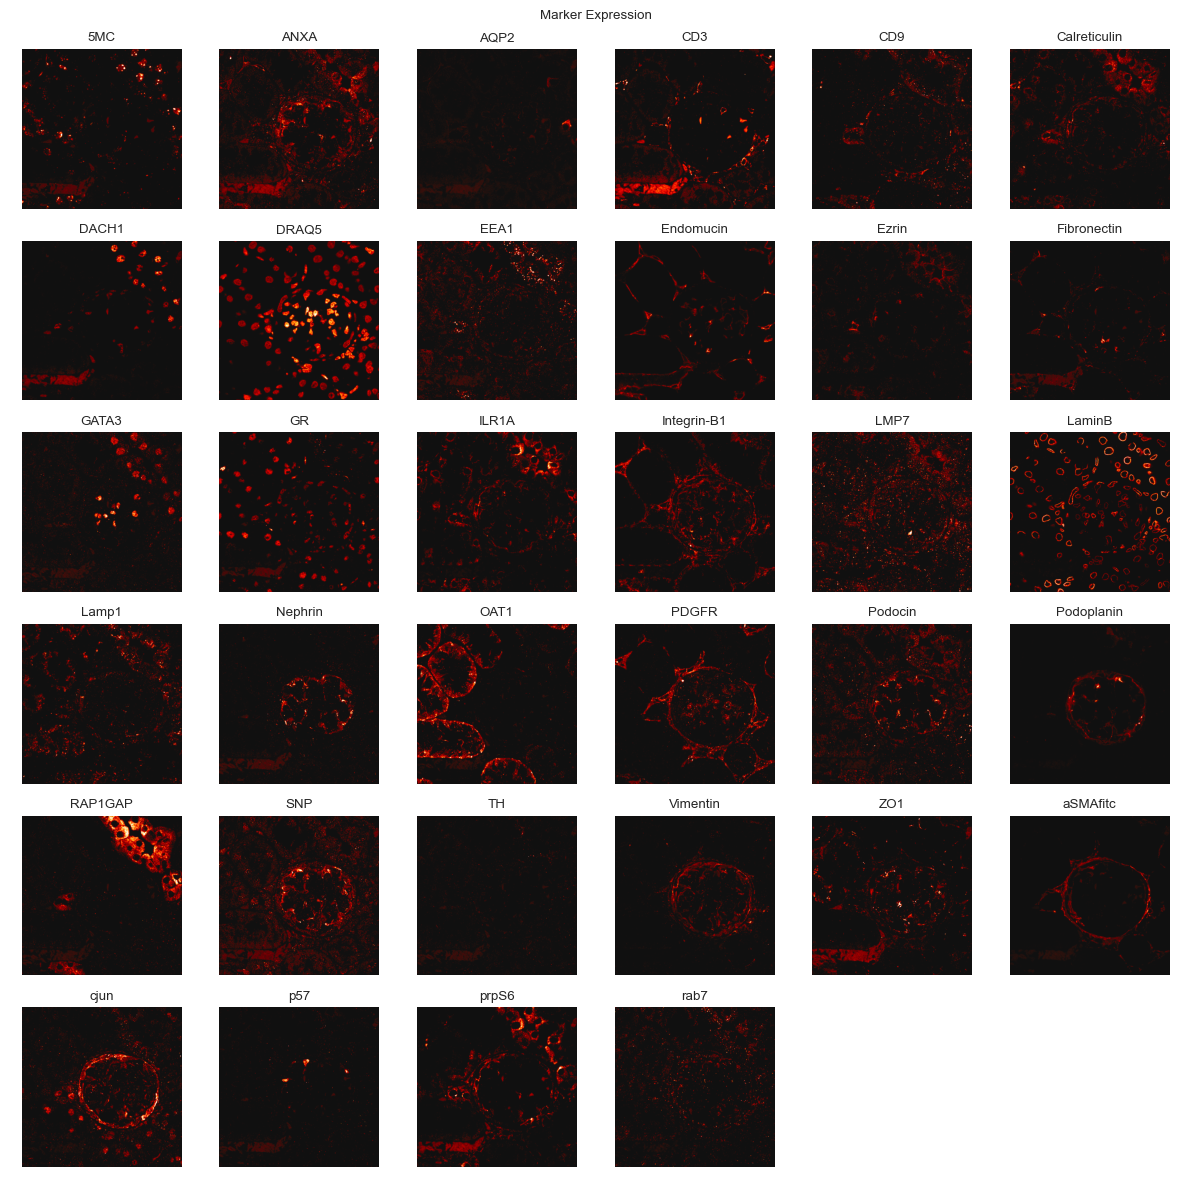

In [14]:
fig = so.plot.marker_expression(
    img_data_processed[0],
    channel_names=channels,
    max_value=1.0,
    figsize=(12, 12),
    colormap=ListedColormap(linear_kryw_5_100_c67),
)

## Self-organizing map training

Even with a subsample, graph clustering would be computationally very slow. If the subsample was clustered directly, rarer signals might also get grouped together with more abundant signals in the neighborhood graph. We therefore first train a self-organizing map to get a dimensionality-reduced representation of the data. This representation can then be used to identify clusters in the data. The number of SOM nodes will determine how many different co-expression signatures can be learned well. For real world datasets, we commonly use values between (100, 100) and (500, 500) with GPU acceleration. For this example, we will use a smaller SOM size, knowing that we might only be able to identify the most abundant and coherent signals.

In [15]:
img_data_som = so.dimension.som(
    node_count=(30, 30),  # we generally recommend higher node counts
    dimension_count=subsample_processed.shape[-1],
    distance_metric="euclidean",  # "euclidean" and "cosine" are the fastest, while there are some theoretical reasons to use "correlation"
    use_gpu=False,
    seed=0,
)

In [16]:
img_data_som.fit(
    subsample_processed,
    iteration_count=10,  # We recommend to start with about 25 and to evaluate the fit in production settings
)
img_data_som.save("./data/mouse_cgn/example_map.p")

100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


You can easily evaluate how well your SOM fits the training data by plotting the distances (here, Euclidean distance) from each data point in the subsample to its corresponding SOM node. What values are considered "good" will depend on the average intensity in your dataset, the number of markers and the distance metric you use. We encourage you to evaluate multiple SOM sizes with few iterations first and once you have identified the approximate size for a SOM that can fit your data well to then train it for more iterations.

In [17]:
quantization_error, distances = img_data_som.get_quantization_error(subsample_processed, return_distances=True)

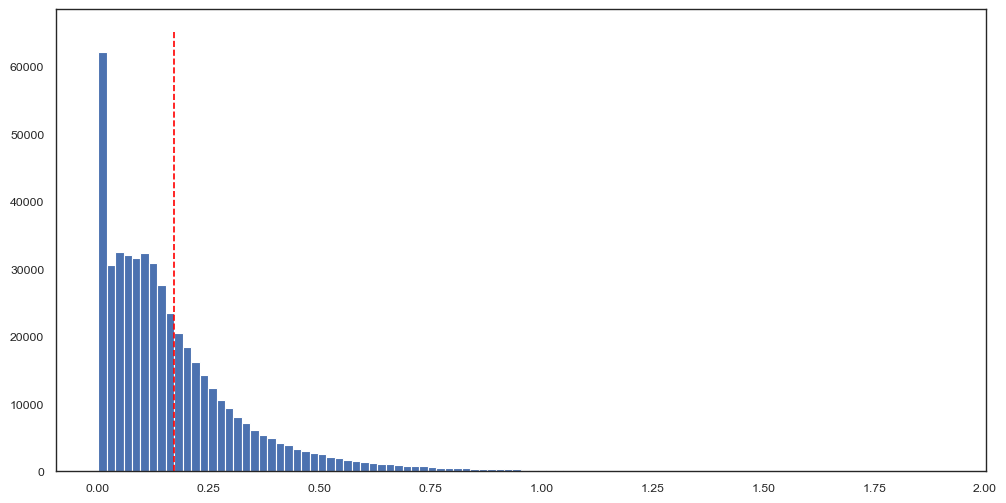

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(
    distances,
    bins=100,
)
ax.vlines(
    quantization_error,
    ymin=0,
    ymax=ax.get_ylim()[1],
    color="red",
    linestyle="--",
)

As a quality control of SOM-fitting, we can examine which SOM nodes express which markers. Spatially co-expressed markers should be closer to each other in the SOM space.

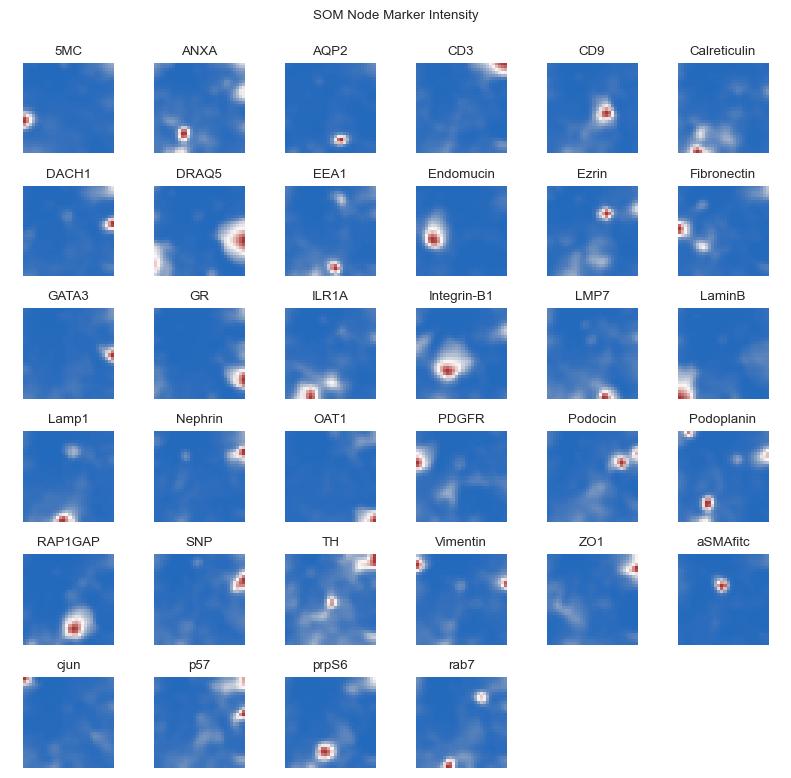

In [19]:
fig = so.plot.som_marker_expression(
    img_data_som.get_nodes(flatten=False),
    figsize=(8, 8),
    channel_names=channels,
)

## Cluster the SOM nodes

To identify pixel clusters of protein co-expression, we use similarity-based graph clustering with Leiden.

In [20]:
# create a k nearest neighbor graph
knn_graph_som = so.neighbor.knn_graph().create(
    img_data_som,
    neighbor_count=12,
    use_gpu=False,
)

In [21]:
# perform Leiden clustering
communities, modularity = so.cluster.leiden().predict(
    knn_graph_som,
    resolution=2.5,  # typically higher resolution values than in scRNA seq experiments
    iteration_count=100,
    seed=42,
    use_gpu=False,
)

In [22]:
len(np.unique(communities)), modularity

(25, 0.7158304531257043)

It can be difficult to evaluate which cluster resolution is best based on the modularity alone, as it is not really comparable between resolutions. It's best practice to check whether your clustering approach can identify expected co-expression patterns by running the subsequent steps. You may also want to use a tool like [pyclustree](https://pyclustree.complextissue.com/stable/example.html) to evaluate different resolutions.

To visualize the clusters, we first need a colormap. For fewer than 100 clusters, we can use the `glasbey_light` colormap from `colorcet`, else we can randomly generate one (set `flavor` to `random_hls` and specify a `seed`). We can always override individual colors in the colormap, e.g., to color background clusters black.

In [23]:
# get the som node with the smallest mean intensity
background_node = np.argmin(np.mean(img_data_som.get_nodes(), axis=1))
background_cluster = communities[background_node]

colormap = so.plot.colormap(
    color_count=np.max(communities) + 1,
    flavor="glasbey",
    color_override={
        background_cluster: "#000000",  # set the empty background to black
    },
)

We can visually inspect the clustered neighborhood graph. Note that such a two-dimensional projection may result in neighbors lying further apart than they actually are.

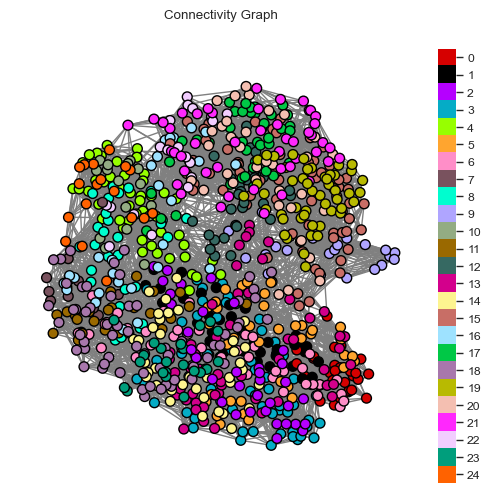

In [24]:
fig = so.plot.connectivity_graph(
    knn_graph_som,
    clusters=communities,
    cluster_legend=True,
    figsize=(5, 5),
    colormap=colormap,
)
fig.set_dpi(100)

We can do the same for the SOM nodes as they are arranged within the self-organizing map.

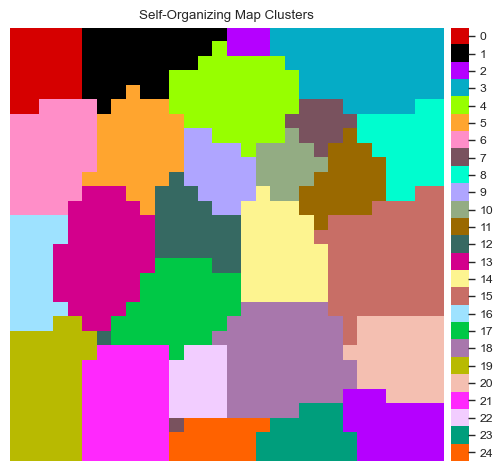

In [25]:
fig = so.plot.som_clusters(img_data_som, communities, colormap=colormap)

You can also visualize the clustering in a UMAP of the SOM nodes.

In [26]:
umap = so.dimension.umap(dimension_count=2, neighbor_count=20, distance_min=0.1, spread=0.5, seed=42, use_gpu=False)
umap_values = umap.fit_transform(img_data_som.get_nodes())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


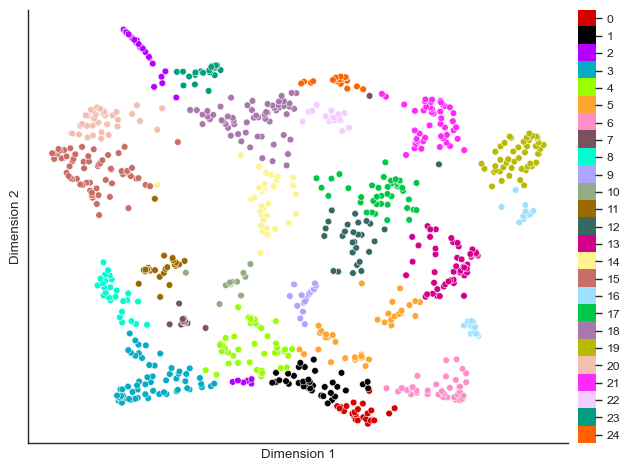

In [27]:
fig = so.plot.cluster_scatter(
    umap_values,
    communities,
    colormap=colormap,
)

## Cluster composition

The composition of the clusters can either be calculated from the representative SOM nodes or from randomly sampled clustered images. The former allows you to just the clustering before applying it to the entire dataset, enabling quicker iterations. The latter represents the dataset slightly more accurately, but is computationally more expensive and generally similar to the representative SOM nodes.

In [28]:
df_stats = so.tool.get_stats(
    img_data_som.get_nodes(),
    group=communities,
    channel_names=channels,
    comparison="all",
    test="t",
    permutation_count=100,  # Setting permutation count will perform a permutation test with the "test" statistic
    equal_variance=False,
    dependent=False,
    correction="fdr",
)

From a previous analysis, we know that there is a cluster that has an increased phospho-c-Jun expression in PECs (an effector cell type in crescentic glomerulonephritis), so let's try to find it.

In [29]:
df_stats_cjun = df_stats[df_stats["marker"] == "cjun"].sort_values("mean_group", ascending=False).head(1)
df_stats_cjun

group comparison marker  p_value_corrected  log10_p_value_corrected  \
30      0        all   cjun           0.039511                 1.403282   

    mean_group  mean_comparison   p_value  log10_p_value ranksum  \
30    0.117867         0.013775  0.019802       1.703291    None   

    log2_fold_change  
30          3.097082

You can then plot the contributors for each cluster with their mean intensity, log2 fold change and p-value. The p-value is not shown on the axis but color-coded.

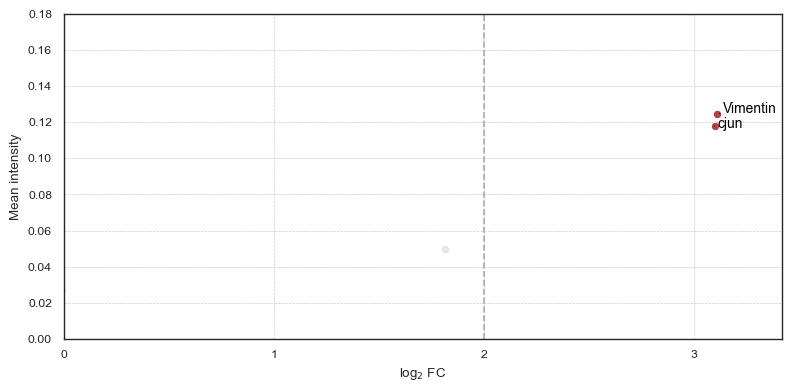

In [30]:
fig = so.plot.cluster_contributors(
    df_stats,
    cluster_idx=df_stats_cjun["group"].to_numpy()[0],
    increased_log2_fold_change_threshold=2,
    log10_p_value_column="log10_p_value_corrected",
    mean_max=0.2,
    figsize=(8, 4),
)
fig.set_dpi(100)

We can also get the mean intensity of all markers for each cluster as a table.

In [31]:
df_cluster_marker_intensity = so.tool.mean_cluster_intensity(
    img_data_som.get_nodes(),
    clusters=communities,
    channel_names=channels,
)
df_cluster_marker_intensity.head()

5MC      ANXA      AQP2       CD3       CD9  Calreticulin     DACH1  \
0  0.004611  0.026990  0.001665  0.006472  0.010657      0.018187  0.003667   
1  0.004613  0.003401  0.001340  0.001712  0.001726      0.001186  0.001491   
2  0.005265  0.008623  0.004845  0.032312  0.004748      0.005965  0.017611   
3  0.045893  0.040196  0.012315  0.171179  0.010708      0.005907  0.077159   
4  0.004895  0.005059  0.002724  0.008685  0.006137      0.008434  0.004887   

      DRAQ5      EEA1  Endomucin  ...   RAP1GAP       SNP        TH  Vimentin  \
0  0.017597  0.013944   0.005845  ...  0.005145  0.021471  0.004766  0.124615   
1  0.002893  0.000763   0.001916  ...  0.000843  0.001944  0.001337  0.001485   
2  0.006173  0.015904   0.003141  ...  0.010980  0.009089  0.014863  0.004299   
3  0.004139  0.027647   0.012415  ...  0.025948  0.019607  0.040096  0.008615   
4  0.002702  0.038363   0.001591  ...  0.005645  0.012481  0.006135  0.002663   

        ZO1  aSMAfitc      cjun       p57     prpS6      rab7  
0  0.011050  0.009301  0.117867  0.006892  0.008928  0.023200  
1  0.001264  0.001277  0.002282  0.001686  0.001138  0.001147  
2  0.017340  0.004963  0.010010  0.019894  0.018631  0.020892  
3  0.106511  0.018705  0.014579  0.065555  0.094898  0.033293  
4  0.006471  0.004740  0.006261  0.007168  0.006891  0.010898  

[5 rows x 34 columns]

For a given cluster, we can plot a histogram of all the intensities of SOM nodes or pixels assigned to that cluster by marker. We again see that Vimentin, Podoplanin and phospho-c-Jun are highly expressed in this cluster and seem to be driving it, as no assigned SOM nodes have a low expression of these markers.

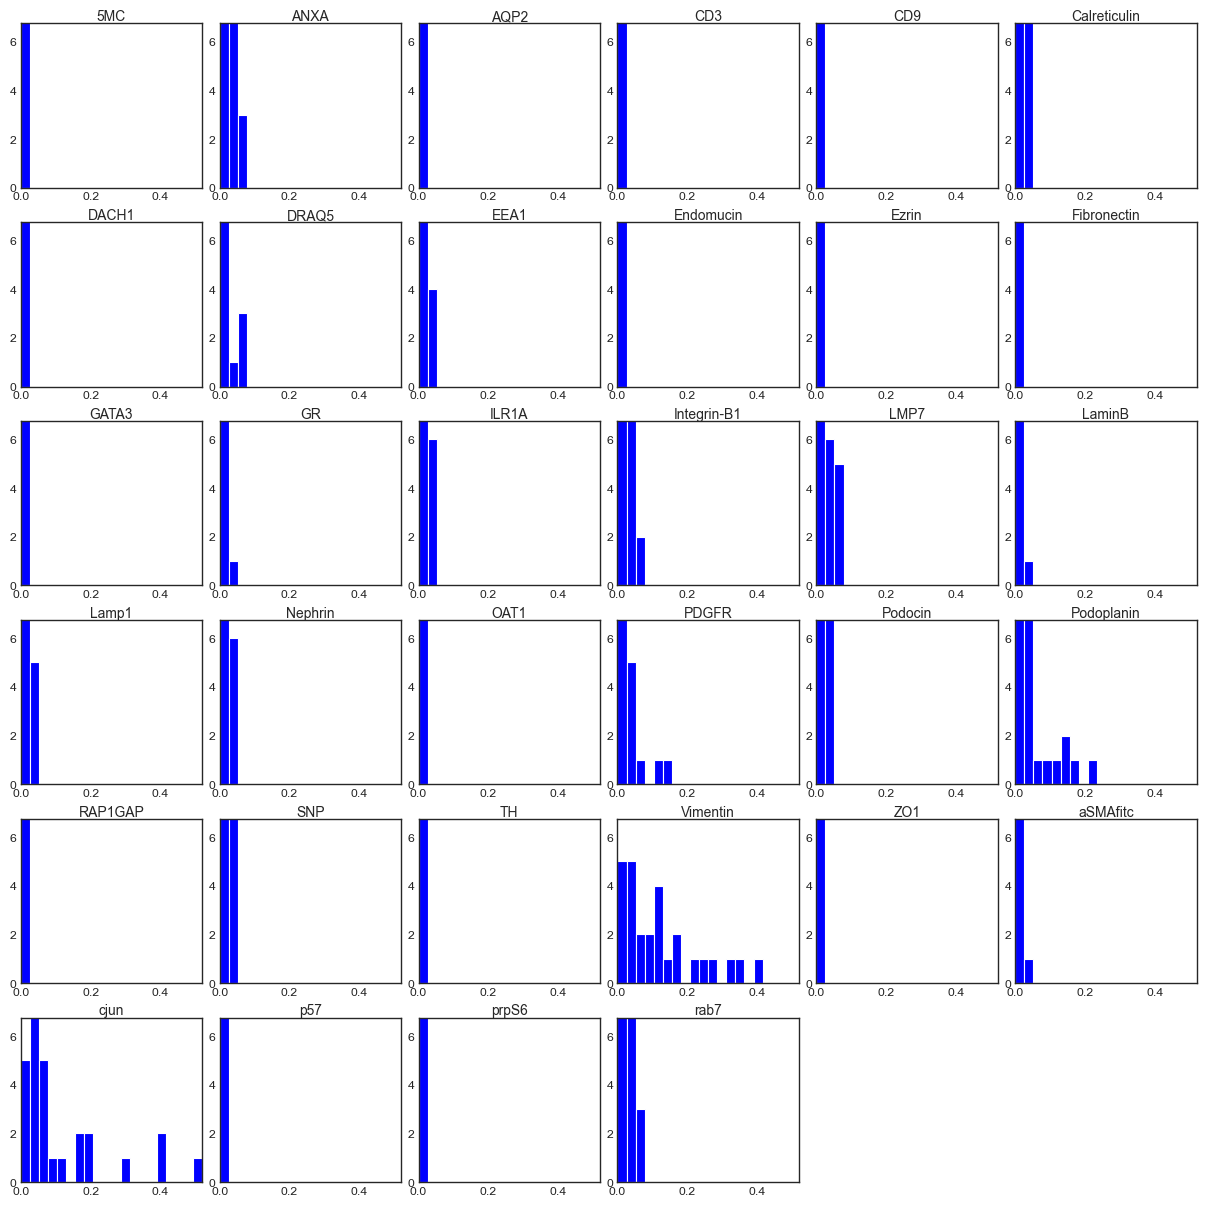

In [32]:
fig = so.plot.cluster_contributor_histogram(
    img_data_som.get_nodes()[np.array(communities) == df_stats_cjun["group"].to_numpy()[0]],
    channel_names=channels,
    bin_count=20,
    scaling_factor_y=0.2,  # play around with this value to adjust the y-axis scaling, smaller values zoom out
)

Vimentin is a cytoskeletal protein that is expressed in PECs but also upregulated in kidney injury or fibrosis. Podoplanin is expressed in both Podocytes and PECs. Phospho-c-Jun is involved in the AP-1 signalling cascade and has previously been indicated to play a role in crescentic glomerulonephritis, though its upregulation in PECs has not been profiled.
However, to fully interpret this signal, we need to evaluate its expression in space. For this, we need to cluster all images in the dataset and perform differential abundance analysis as well as spatial projection.

## Clustering of entire images

In [33]:
for image, image_name in tqdm(zip(img_data_processed, images)):
    clustered_image = img_data_som.label(
        image,
        communities,
        save_path=f"./data/mouse_cgn/{image_name}-labelled.npy",
    )

    so.plot.save_cluster_image(
        clustered_image,
        f"./data/mouse_cgn/{image_name}-labelled.png",
        colormap=colormap,
    )

12it [00:09,  1.32it/s]


You can view the cluster projection in space (shown in the downsampled example image, PathoPlex can provide higher resolution images).

In [34]:
labelled_image = np.load(f"./data/mouse_cgn/{images[0]}-labelled.npy")

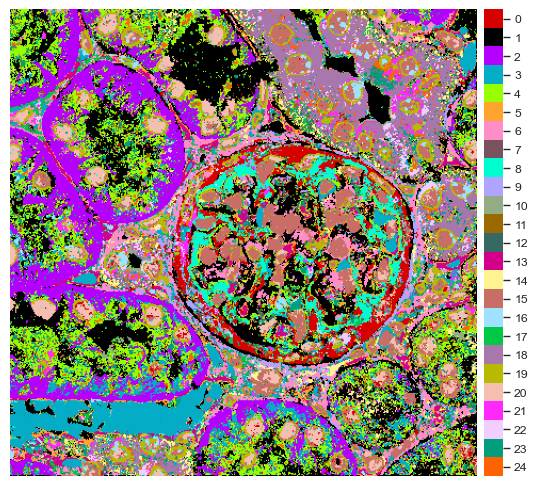

In [35]:
fig = so.plot.cluster_image(
    labelled_image,
    colormap=colormap,
)

It's always useful to get a legend for the cluster colors separately.

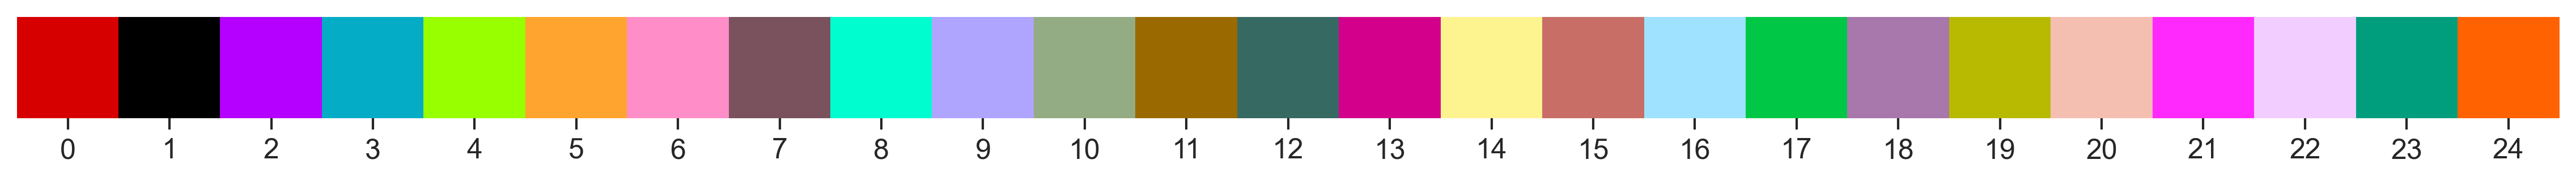

In [36]:
fig = so.plot.cluster_legend(
    cluster_count=len(np.unique(communities)),
    cluster_labels=[f"{i}" for i in range(len(np.unique(communities)))],
    colormap=colormap,
)

We can evaluate the location of each cluster individually.

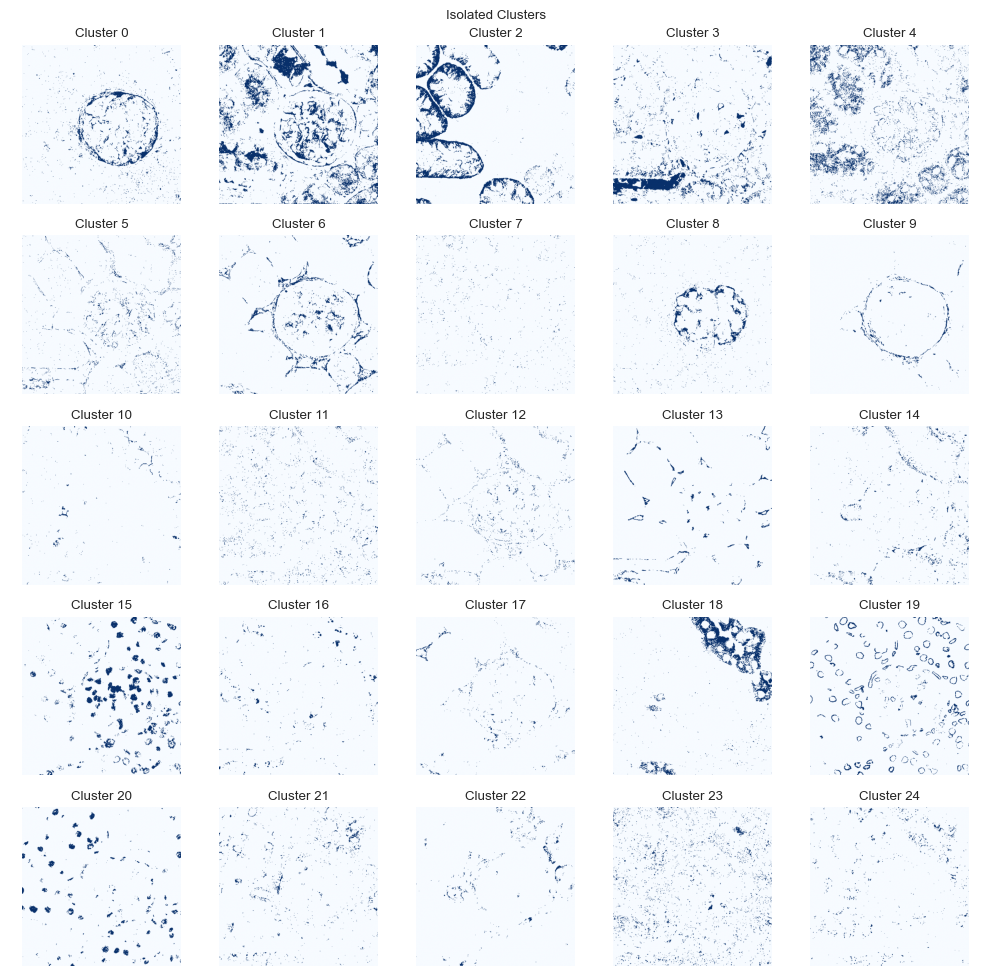

In [37]:
fig = so.plot.cluster_location(labelled_image)

## Differential abundance analysis

One of the main goals of `spatiomic` analyses is to generate a cluster abundance count matrix to perform differential cluster abundance analysis. First, we have to quantify the cluster abundance in each image (and if there are multiple images per sample, aggregate them per sample).

In [38]:
df_cluster_counts = so.tool.count_clusters(
    [f"./data/mouse_cgn/{image}-labelled.npy" for image in images],
    cluster_count=len(np.unique(communities)),
    normalize=True,
)

Since in this case we had two FOVs per sample, we need to aggregate the counts at the sample level.

In [39]:
df_cluster_counts["sample"] = [file_path.split("mouse_cgn/")[-1].split(" ")[0] for file_path in df_cluster_counts.index]
df_cluster_counts["disease"] = [is_disease[samples.index(sample)] for sample in df_cluster_counts["sample"]]
df_cluster_counts = df_cluster_counts.groupby("sample").mean()
df_cluster_counts.head()

0         1         2         3         4         5         6  \
sample                                                                         
245     0.042511  0.197194  0.096740  0.080365  0.106037  0.024640  0.048558   
247     0.053392  0.276545  0.083860  0.035169  0.078509  0.030311  0.070987   
248     0.058078  0.117252  0.038768  0.032735  0.063408  0.031455  0.050101   
263     0.039960  0.080352  0.058008  0.227049  0.020381  0.062577  0.017673   
265     0.019310  0.159249  0.042464  0.224151  0.029232  0.037437  0.030666   

               7         8         9  ...        16        17        18  \
sample                                ...                                 
245     0.007894  0.024882  0.014092  ...  0.009659  0.013649  0.037171   
247     0.012349  0.019247  0.013693  ...  0.010681  0.000943  0.047463   
248     0.022112  0.039128  0.009164  ...  0.026579  0.031685  0.017603   
263     0.007152  0.027327  0.020272  ...  0.031966  0.035174  0.056387   
265     0.011522  0.027254  0.010065  ...  0.021994  0.028085  0.053945   

              19        20        21        22        23        24  disease  
sample                                                                       
245     0.044020  0.039185  0.019534  0.008106  0.032837  0.009583      1.0  
247     0.049736  0.028797  0.013923  0.011999  0.025925  0.013063      1.0  
248     0.058772  0.056637  0.046788  0.012604  0.031351  0.035318      1.0  
263     0.017832  0.049858  0.048813  0.017298  0.018804  0.009271      0.0  
265     0.031523  0.030494  0.031812  0.007433  0.013039  0.012169      0.0  

[5 rows x 26 columns]

We can plot a PCA of the cluser abundances. Note the comparatively increased heterogeneity of the disease samples compared to the control samples.

(6, 2)


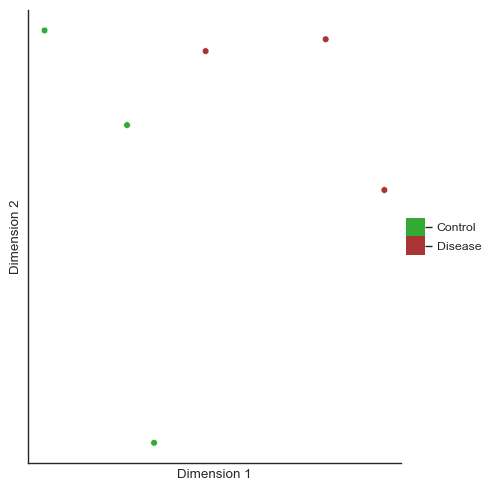

In [40]:
pca = so.dimension.pca(dimension_count=2, use_gpu=False)
pca_values = pca.fit_transform(df_cluster_counts.to_numpy()[:, :-1])
print(pca_values.shape)
condition = ["Disease" if disease else "Control" for disease in df_cluster_counts["disease"].to_numpy()]

fig = so.plot.cluster_scatter(
    pca_values,
    clusters=condition,
    colormap=ListedColormap(["#33AA33", "#AA3333"]),
    figsize=(5, 5),
)

The first PCA dimension seems to differentiate the samples well and explains most of the variance seen in the cluster abundance data.

In [41]:
pca.get_explained_variance_ratio()

array([0.68732449, 0.22635426])

We can also plot the loadings of the first PC to see which clusters seem to be driving the separation.

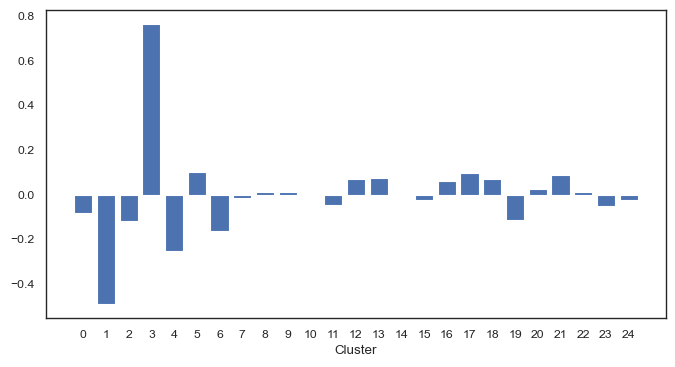

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(
    x=df_cluster_counts.columns[:-1].to_numpy().astype(np.uint8),
    height=pca.get_loadings()[0],
)
ax.set_xticks(df_cluster_counts.columns[:-1].to_numpy().astype(np.uint8))
ax.set_xlabel("Cluster")
plt.show()

The PCA plot already indicates differences between the disease and non-disease samples. We can visuallize differential cluster abundance with a volcano plot following statistical testing.

In [43]:
df_stats_abundance = so.tool.get_stats(
    df_cluster_counts.iloc[:, :-1].to_numpy(),
    group=df_cluster_counts["disease"].to_numpy(),
    channel_names=df_cluster_counts.columns,
    comparison=0,  # Choose your control group
    test="t",
    equal_variance=False,  # Use Welch's t-test
    dependent=False,
    correction=None,  # For larger sample sizes, you can use "fdr", "holm-sidak" or "bonferroni"
    test_kwargs={},
)

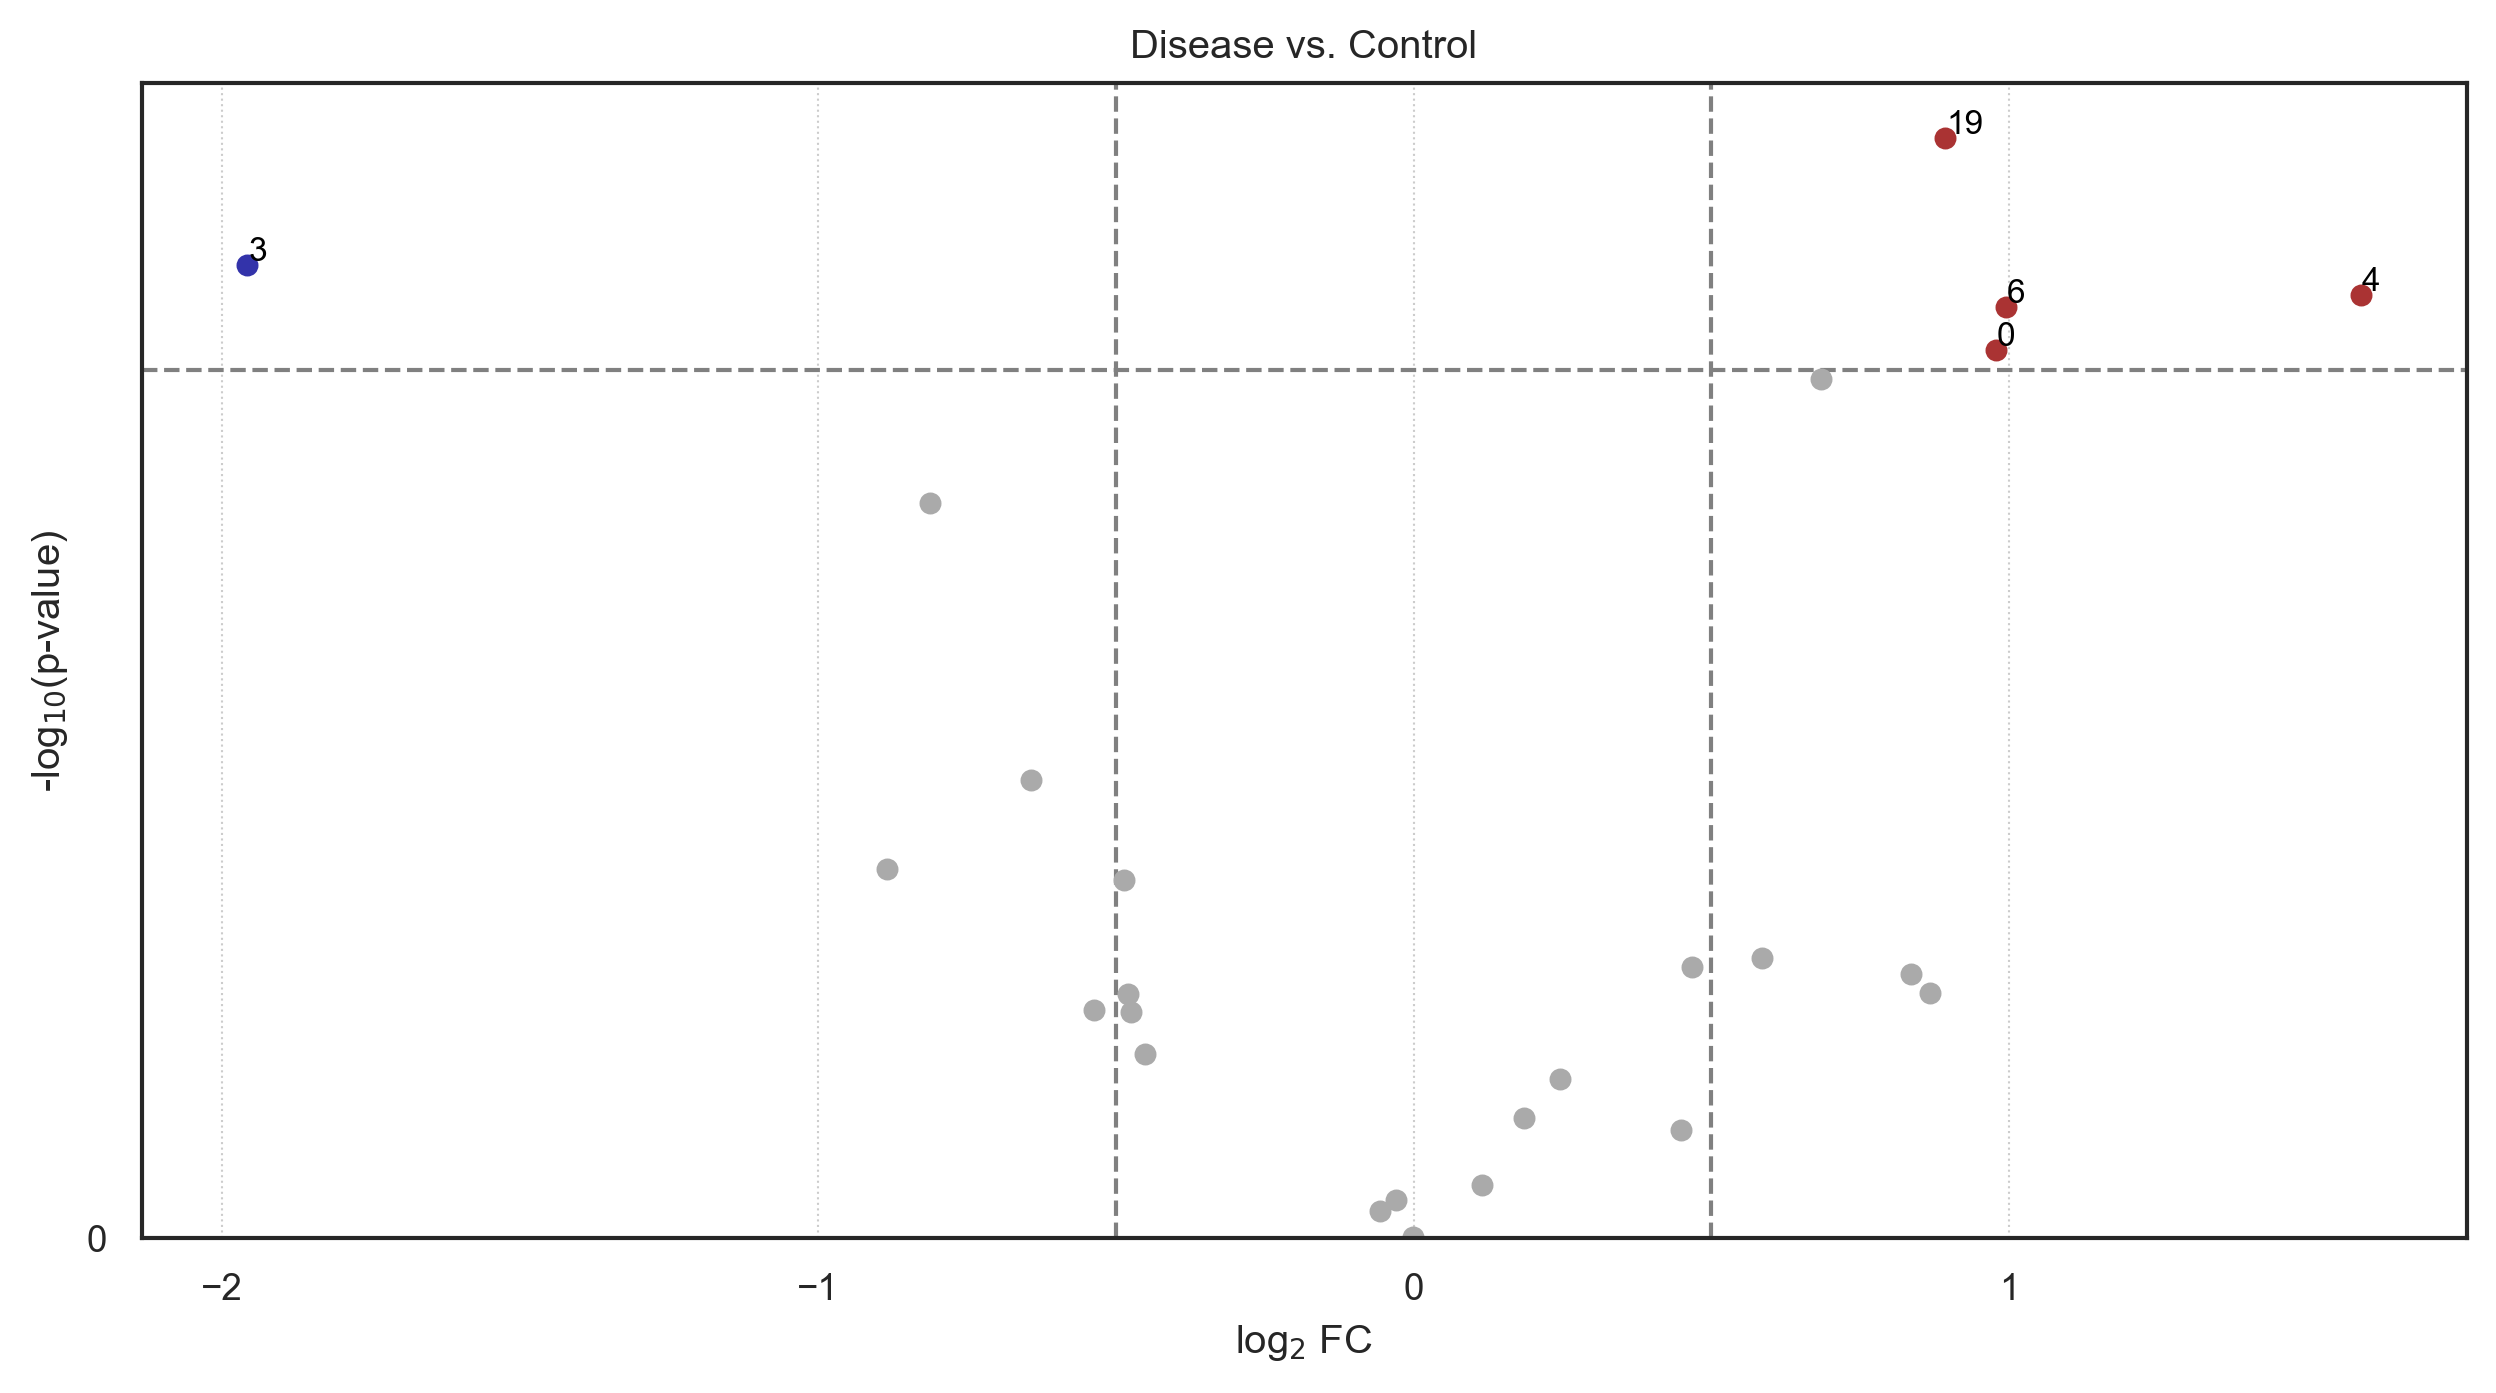

In [44]:
fig = so.plot.volcano(
    df_stats_abundance,
    channel_column="marker",
    title="Disease vs. Control",
    significant_log2_fold_change_threshold=0.5,
)

We can see, that even a downscaled analysis on two FOVs per sample already identifies the over-expression of phospho-c-Jun and Vimentin within the same pixels as a defining feature of the disease group.

In [45]:
df_stats_abundance_significant = df_stats_abundance[
    (df_stats_abundance["p_value"] < 0.05)
    & ((df_stats_abundance["log2_fold_change"] > 0.5) | (df_stats_abundance["log2_fold_change"] < -0.5))
].sort_values("log2_fold_change", ascending=False)
df_stats_abundance_significant

group  comparison  marker p_value_corrected log10_p_value_corrected  \
4     1.0         0.0       4              None                    None   
6     1.0         0.0       6              None                    None   
0     1.0         0.0       0              None                    None   
19    1.0         0.0      19              None                    None   
3     1.0         0.0       3              None                    None   

    mean_group  mean_comparison   p_value  log10_p_value ranksum  \
4     0.082651         0.027449  0.038524       1.414265    None   
6     0.056549         0.028378  0.040201       1.395763    None   
0     0.051327         0.026062  0.046583       1.331775    None   
19    0.050843         0.027398  0.022410       1.649567    None   
3     0.049423         0.191962  0.034745       1.459106    None   

    log2_fold_change  
4           1.590265  
6           0.994712  
0           0.977780  
19          0.891958  
3          -1.957564

In [46]:
for marker in df_stats_abundance_significant["marker"]:
    df_stats_cluster = df_stats[df_stats["group"] == marker]
    df_stats_cluster_significant = df_stats_cluster[
        (df_stats_cluster["p_value"] < 0.05)
        & (np.abs(df_stats_cluster["log2_fold_change"]) > 0.5)
        & (np.abs(df_stats_cluster["mean_group"]) > 0.03)
    ].sort_values("log2_fold_change", ascending=False)

    print(f"Differentially abundant cluster {marker} consists of: " + ", ".join(df_stats_cluster_significant["marker"]))

Differentially abundant cluster 4 consists of: EEA1
Differentially abundant cluster 6 consists of: PDGFR
Differentially abundant cluster 0 consists of: Vimentin, cjun, Podoplanin
Differentially abundant cluster 19 consists of: LaminB, DRAQ5, Calreticulin, GR
Differentially abundant cluster 3 consists of: CD3, ZO1, p57, DACH1, TH, OAT1, prpS6, Fibronectin, Nephrin, 5MC, GR, ANXA


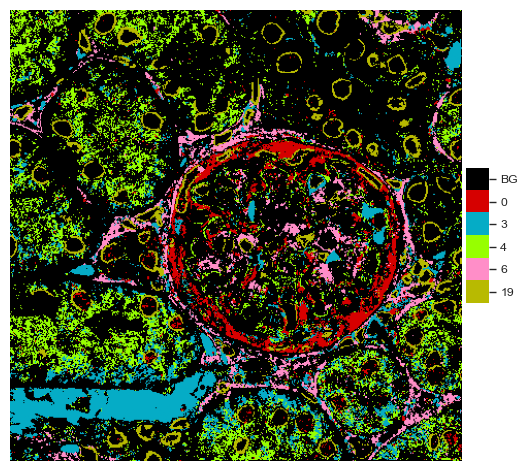

In [47]:
fig = so.plot.cluster_selection(
    labelled_image,
    clusters=df_stats_abundance_significant["marker"].head(5).to_numpy(),
    colormap=colormap,
)

## Spatial analysis

Now we know which clusters are differentially abundant between groups, where they are located within images and what markers are driving them. But we can go a bit further and also evaluate which clusters are located near one another. First, we create a neighborhood offset with the radius of interest. This way, we can evaluate the spatial relationship at different distances. Here, we look at a queen neighborhood of 5 pixels.

In [48]:
neighborhood_offset = so.spatial.neighborhood_offset(
    neighborhood_type="queen",
    order=2,
    exclude_inner_order=0,  # note that 0, 0 will always be excluded
)

In [49]:
dfs_vicinity_composition = []

for image in tqdm(images):
    clustered_data = np.load(f"./data/mouse_cgn/{image}-labelled.npy")
    df_vicinity_composition = so.spatial.vicinity_composition(
        clustered_data,
        neighborhood_offset=neighborhood_offset,
        ignore_identities=True,
        ignore_repeated=True,
        use_gpu=False,
    )

    dfs_vicinity_composition.append(df_vicinity_composition)

dfs_vicinity_composition[0].head()

100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


0     1     2     3     4     5     6    7    8    9   ...   15   16   17  \
0    0  1015   117   219   401   143   298  100  521  314  ...  328   51   67   
1  741     0  1351  1130  3991  1008  1040  105  395  345  ...  404  121   75   
2  109  1336     0  1274  1932   292   302  265   62   30  ...   51   92  125   
3  286  1072  1227     0  1297   347   469  131  172   75  ...  270  106  111   
4  434  4039  1981  1271     0   317   216  206  360   48  ...  246   85   29   

    18   19   20   21   22    23   24  
0   78  294  210  145   84   167   78  
1  298  290  274  159   75   883  137  
2   62  242   57  134   44   476  101  
3  156  250   78  182  117   347  117  
4  293  452  172  334   49  1252  527  

[5 rows x 25 columns]

We can combine the vicinity composition of individual images for the entire dataset and for each group.

In [50]:
df_vicinity_composition_overall = pd.concat(dfs_vicinity_composition).groupby(level=0).sum()

dfs_vicinity_composition_disease = [
    df for df, disease in zip(dfs_vicinity_composition, is_disease, strict=True) if disease
]
dfs_vicinity_composition_control = [
    df for df, disease in zip(dfs_vicinity_composition, is_disease, strict=True) if not disease
]

df_vicinity_composition_disease = pd.concat(dfs_vicinity_composition_disease).groupby(level=0).sum()
df_vicinity_composition_control = pd.concat(dfs_vicinity_composition_control).groupby(level=0).sum()

From this data, we can generate a vicinity graph and visualize it.

In [51]:
vicinity_graph = so.spatial.vicinity_graph(
    df_vicinity_composition_overall,
)

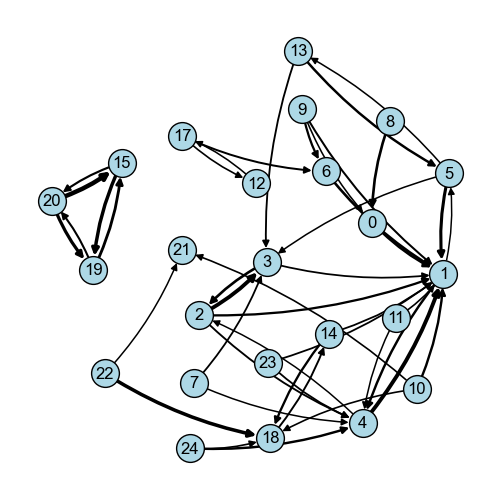

In [52]:
fig = so.plot.spatial_graph(
    vicinity_graph,
    edge_threshold=0.1,
)
fig.set_size_inches(5, 5)
fig.set_dpi(100)

We can already identify a heavily interconnected group of clusters. Let's look at their composition. Note, that while the code is deterministic on a given computer, which clusters are nuclear might change between machines and operating systems.

In [53]:
clusters = [15, 19, 20]
for cluster in clusters:
    df_stats_cluster = df_stats[df_stats["group"] == cluster]
    df_stats_cluster_significant = df_stats_cluster[
        (df_stats_cluster["p_value_corrected"] < 0.05)
        & (np.abs(df_stats_cluster["log2_fold_change"]) > 0.5)
        & (np.abs(df_stats_cluster["mean_group"]) > 0.05)
    ].sort_values("log2_fold_change", ascending=False)

    print(f"Cluster {cluster} consists of: " + ", ".join(df_stats_cluster_significant["marker"]))

Cluster 15 consists of: DRAQ5, GATA3, DACH1
Cluster 19 consists of: LaminB, DRAQ5
Cluster 20 consists of: GR, DRAQ5


All these clusters seem to represent nuclear signals, which is why they are spatially co-located. We can confirm this in space again.

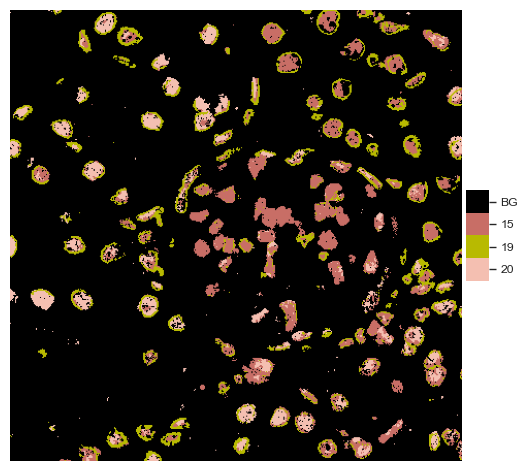

In [54]:
fig = so.plot.cluster_selection(
    labelled_image,
    clusters=clusters,
    colormap=colormap,
)

Now, let's evaluate the differences in cluster vicinities between groups.

In [55]:
vicinity_graph_disease = so.spatial.vicinity_graph(
    df_vicinity_composition_disease,
)

vicinity_graph_control = so.spatial.vicinity_graph(
    df_vicinity_composition_control,
)

The `spatial_graph` plotting function allows us to specify a reference graph. Increased connections are shown in red, decreased connections in blue.

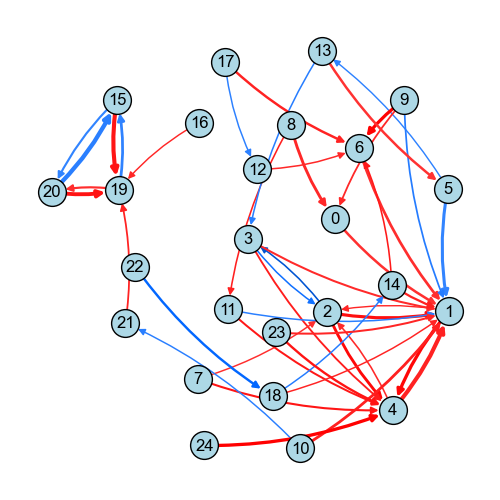

In [56]:
fig = so.plot.spatial_graph(
    vicinity_graph_disease,
    reference_graph=vicinity_graph_control,
    edge_threshold=0.1,
)
fig.set_size_inches(5, 5)
fig.set_dpi(100)

We can see that the connection between cluster 9 (an alpha-SMA cluster) and cluster 6 (a PDGFR cluster) increases in the disease group. Both signals are implicated in pro-fibrotic responses.

In [57]:
clusters = [6, 9]
for cluster in clusters:
    df_stats_cluster = df_stats[df_stats["group"] == cluster]
    df_stats_cluster_significant = df_stats_cluster[
        (df_stats_cluster["p_value_corrected"] < 0.05)
        & (np.abs(df_stats_cluster["log2_fold_change"]) > 0.5)
        & (np.abs(df_stats_cluster["mean_group"]) > 0.05)
    ].sort_values("log2_fold_change", ascending=False)

    print(f"Cluster {cluster} consists of: " + ", ".join(df_stats_cluster_significant["marker"]))

Cluster 6 consists of: PDGFR
Cluster 9 consists of: aSMAfitc


We can evaluate the significance of these changes with a permutation test. Instead of reyling on the t-statistic or the t-test, we can define our own test statistic.

In [58]:
def compare_means(data, data_comparison, **kwargs):
    """Compare means of two groups."""
    return np.mean(data, axis=0) - np.mean(data_comparison, axis=0)


join_counts = np.expand_dims(
    np.array([df.iloc[9, 6] / df.iloc[9].sum() for df in dfs_vicinity_composition]),
    axis=-1,
)

df_stats_vicinity = so.tool.get_stats(
    join_counts,
    group=is_disease,
    channel_names=["join_counts"],
    comparison=0,
    test=compare_means,
    dependent=False,
    correction=None,
    permutation_count=1000,
    permutation_seed=42,
)

In [59]:
df_stats_vicinity["p_value"]

0    0.02381
Name: p_value, dtype: float64

The increased spatial enrichment of cluster 6 around pixels assigned to cluster 9 appears to be statistically significant at the 0.05 level of significance.

## Visualizing all clustered images

Now that we know which clusters are upregulated and what spatial relationships they have, we can visualize all images in the dataset with the cluster assignments.

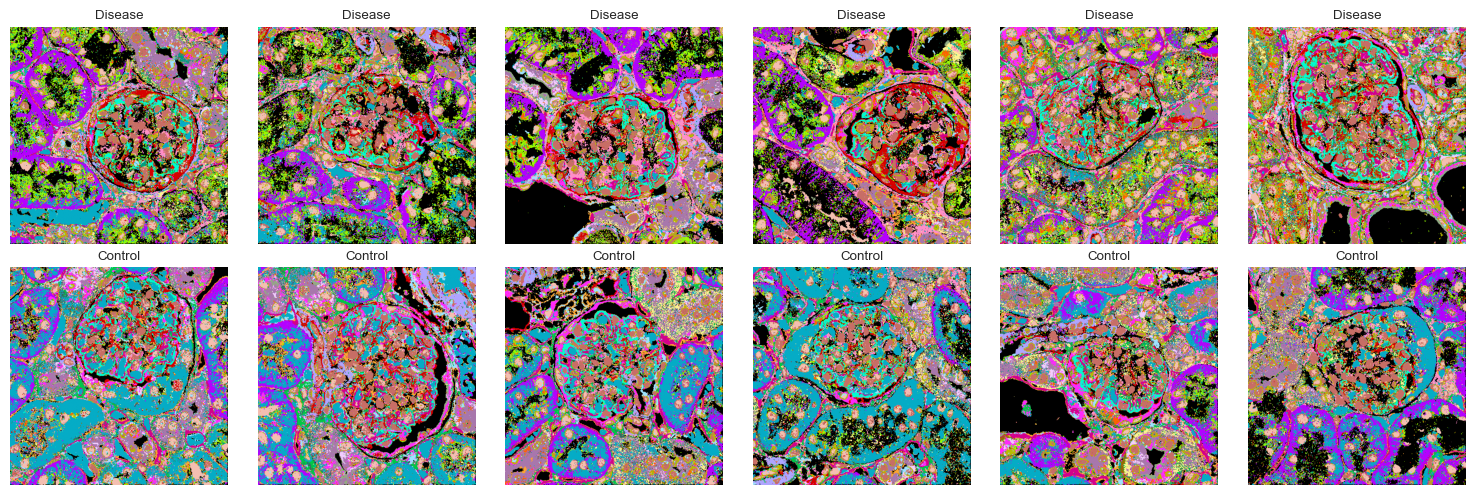

In [60]:
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for ax, image in zip(axes.flatten(), images, strict=True):
    clustered_image = np.load(f"./data/mouse_cgn/{image}-labelled.npy")
    ax.imshow(clustered_image, cmap=colormap)
    ax.axis("off")
    ax.set_title("Control" if not is_disease[images.index(image)] else "Disease")

plt.tight_layout()

## Extended analyses

`spatiomic` builds upon fundamental data structures in the scientific Python ecosystem, e.g., NumPy arrays and pandas DataFrames. Many function also accept an `AnnData` object as input. Similarily, the `spatial` submodule of `spatiomic` largely relies on the `pysal` weights object. This allows for a seamless integration with other community tools, such as `esda` or `squidpy`. Please refer to the PathoPlex manuscript that first introduced the `spatiomic` package for example analyses using `spatiomic` output with `MistyR`, `PILOT`, `UnPaSt`, `Cellpose` and other tools.

E.g., based on the neighborhood offset generated above, we can create a spatial weights matrix for a given image to use with `pysal` and `esda`. For Python examples of `esda` for spatial analyses, please refer to the `pasta` spatial statistics guide for which we have contributed Python examples, specifically to all sections dealing with lattice-based data: [pasta spatial statistics guide](https://robinsonlabuzh.github.io/pasta/00-home.html).

In [61]:
spatial_weights = so.spatial.spatial_weights(
    data_shape=labelled_image.shape,
    neighborhood_offset=neighborhood_offset,
)

Creating spatial weights for each offset: 100%|██████████| 24/24 [00:00<00:00, 1726.23it/s]


We can also easily convert each image to an `AnnData` object for use with `scverse®` tools.

In [62]:
adata = so.data.anndata_from_array(
    img_data_processed[-4],
    channel_names=channels,
    clusters=labelled_image,
    cluster_key="cluster",
    spatial_weights=spatial_weights,
)
adata

AnnData object with n_obs × n_vars = 191844 × 34
    obs: 'cluster'
    obsm: 'spatial'
    obsp: 'spatial_connectivities'

You can also refer to the spatial statistics tutorial included in this documentation for more examples of built-in methods and interoperability with `esda`. Please note that the spatial statistics functionality shown there is still actively developed, not fully covered by unittests and might change in the future.

## Time evaluation

Let's see how long it took to run this example on a MacBook Pro with M2 Max chip but no CUDA-enabled GPU.

In [63]:
time_end = get_time()
time_execution = time_end - time_start

print(f"Execution time: {time_execution:.2f} seconds")

Execution time: 82.92 seconds


## Session info

In [64]:
info = session_info(
    cpu=True,
    gpu=True,
)  # note that the output cannot be copied in the compiled docs version of this notebook
info

anndata	0.11.4
pandas	2.2.3
matplotlib	3.10.1
numpy	2.2.4
scikit-image	0.25.2
tqdm	4.67.1
spatiomic	0.4.0
requests	2.32.3
igraph	0.11.8
networkx	3.4.2
libpysal	4.13.0
----	----
Python	3.12.6 (main, Sep 29 2024, 12:25:04) [Clang 16.0.0 (clang-1600.0.26.3)]
OS	macOS-15.3.1-arm64-arm-64bit
CPU	12 logical CPU cores, arm
GPU	No GPU found
Updated	2025-04-17 13:34

For the online documentation, we can also print the session info as plain text.

In [65]:
for part in info._repr_mimebundle_()["text/markdown"].split("\n"):
    print(part)

| Package      | Version |
| ------------ | ------- |
| anndata      | 0.11.4  |
| pandas       | 2.2.3   |
| matplotlib   | 3.10.1  |
| numpy        | 2.2.4   |
| scikit-image | 0.25.2  |
| tqdm         | 4.67.1  |
| spatiomic    | 0.4.0   |
| requests     | 2.32.3  |
| igraph       | 0.11.8  |
| networkx     | 3.4.2   |
| libpysal     | 4.13.0  |

| Dependency                    | Version                |
| ----------------------------- | ---------------------- |
| sphinxcontrib-jquery          | 4.1                    |
| esda                          | 2.7.0                  |
| pyarrow                       | 19.0.1                 |
| idna                          | 3.10                   |
| zarr                          | 2.18.7                 |
| tifffile                      | 2025.3.30              |
| asttokens                     | 3.0.0                  |
| psutil                        | 7.0.0                  |
| comm                          | 0.2.2                  |